# 7.2 - Sınıflandırma Problemler: Lojistik Regresyon ile Sınıflandırma
1) Bu ödevde, modelinizi kullanarak Titanic faciasında hayatta kalma durumunu tahmin edeceksiniz. Bu ödevi tamamlamak için, aşağıdaki görevlerin çözümlerini içeren bir Jupyter not defterini link olarak gönderin. Kafanıza takılan konuları mentörünüzle konuşabilir ya da ofis saatinde Slack üzerinden sorabilirsiniz.
* [Titanic](https://www.kaggle.com/c/titanic/data) verilerini Kaggle'dan indirin. Buradaki train.csv dosyasındaki veriler ihtiyacınızı görecektir.
* Verilerinizi eğitim ve test kümelerine ayırın.
* Modelinizi oluşturarak ayırdığınız test kümesindeki verilere göre hayatta kalma durumlarını tahmin edin
* Modelinizin performansı tatmin edici mi? Açıklayın.
* Bazı değişkenleri ekleyerek veya çıkararak modelinizi tahmin performansı açısından geliştirmeye çalışın.

2) Lojistik Regresyon'un avantaj ve dezavantajlarını araştırın ve mentörünüzle tartışın.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings; warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, PolynomialFeatures

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

title_font = {"family":"arial", "color":"black", "weight":"bold", "size":16}
axis_font = {"family":"serif", "color":"gray", "weight":"normal", "size":14}

train_data = pd.read_csv("titanic_train.csv")
test_data = pd.read_csv("titanic_test.csv")

In [2]:
# train data
train_data.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [3]:
# test data
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 27.8+ KB


In [6]:
test_data[test_data.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [7]:
# Bu tek boş değeri, değişkenin ortalaması ile dolduralım.
test_data.loc[152, "Fare"] = test_data.Fare.mean()

In [8]:
# Kategorik değişkenleri numerik yapalım ve boş değerlerle ilgilenelim.
for data in (train_data, test_data):
    # Cinsiyet değişkenini ikili değere dönüştürdük.
    is_male_series = pd.get_dummies(data["Sex"], drop_first=True)
    data.insert(loc=4, column="is_male", value=is_male_series)
    data.drop(labels="Sex", axis=1, inplace=True)
    
    # 3 farklı biniş limanını sayısal değere dönüştürdük
    data.Embarked = data.Embarked.replace("S", 3)    # S = Southampton
    data.Embarked = data.Embarked.replace("Q", 2)    # Q = Queenstown
    data.Embarked = data.Embarked.replace("C", 1)    # C = Cherbourg
    data.Embarked = data.Embarked.replace(np.nan, 0)
    
    # Sayısal değere dönüşen sütunun veri tipini güncelledik.
    data.Embarked = data.Embarked.astype("uint8")
del data

In [9]:
# "Age" değişkenindeki boş değerleri, cinsiyet ortalamalarıyla değiştirdik.
for data in (train_data, test_data):
    temp_index = 0
    for age in (data.Age):
        if np.isnan(age):
            mean_age_by_sex = data.Age.groupby(by=data.is_male).mean()
            data.loc[temp_index, "Age"] = mean_age_by_sex[data.is_male[temp_index]]
        temp_index +=1
del data

In [10]:
# Modelimizin bağımsız ve bağımlı değişkenlerini tanımlayalım.
# Ayrıca, bağımsız değişkenleri standartlaştırarak olası katsayı ağırlık farklarını düşürelim.
X_train = scale(train_data[["Pclass", "is_male", "Fare", "Age", "SibSp", "Parch", "Embarked"]])
Y_train = train_data["Survived"]

# Lojistik Regresyon Modeli Parametreleri:

In [11]:
# Kuracağımız modelde, farklı C değerleri deneyeceğiz.
# C: Inverse of regularization strength 
C_values = np.logspace(-10, 10, 500)

In [12]:
%%time
accuracy_values = pd.DataFrame(columns=["C Values", "Train Accuracy"])
for c in C_values:
    logistic_reg = LogisticRegression(penalty="l1", 
                                      solver="saga", 
                                      multi_class="multinomial", 
                                      C=c, 
                                      max_iter=2000)
    logistic_reg.fit(X_train, Y_train)
    score = logistic_reg.score(X_train, Y_train)
    
    accuracy_values = accuracy_values.append({"C Values":c, "Train Accuracy":score}, 
                                             ignore_index=True)

Wall time: 4.28 s


In [13]:
print("Bazı C değerlerinin doğruluk oranları:")
accuracy_values.iloc[0:500:100]

Bazı C değerlerinin doğruluk oranları:


,C Values,Train Accuracy
0,1.000000e-10,0.616162
100,1.018629e-06,0.616162
200,1.037605e-02,0.786756
300,1.056935e+02,0.801347
400,1.076624e+06,0.801347


In [14]:
index_of_max = accuracy_values.index[accuracy_values["Train Accuracy"] 
                      == accuracy_values["Train Accuracy"].max()][0]

accuracy_of_max = accuracy_values["Train Accuracy"][index_of_max]
c_of_max = accuracy_values["C Values"][index_of_max]

print(f"En yüksek skorun ({accuracy_of_max:.3f}) C değeri: {c_of_max:.4g}")

En yüksek skorun (0.801) C değeri: 0.05464


In [15]:
log_reg = LogisticRegression(solver="lbfgs", 
                             multi_class="multinomial", 
                             C=c_of_max, 
                             max_iter=2000)

log_reg.fit(X_train, Y_train)
print("İlk modelimizin performansı: {:.4f}".format(log_reg.score(X_train, Y_train)))

İlk modelimizin performansı: 0.8002


In [16]:
# "polynomial features" ile değişkenlerimizin etkileşimini gözlemleyeceğiz
poly_model = PolynomialFeatures(degree=5, interaction_only=False, order="C")
X_train_poly = poly_model.fit_transform(X_train)

In [17]:
%%time
# Uygulanan model: 
# log_reg = LogisticRegression(solver="lbfgs", multi_class="multinomial", C=c_of_max, max_iter=1000)
log_reg.fit(X_train_poly, Y_train)
print("5. derece polinom etkileşimi ile denen ilk modelin performansı: {:.4f}".format(log_reg.score(X_train_poly, Y_train)))

5. derece polinom etkileşimi ile denen ilk modelin performansı: 0.8777
Wall time: 6.17 s


In [18]:
# Kabin sütununu da numerik değerler ile güncelleyerek performanstaki değişime bakalım.

for df in (train_data, test_data):
    for index in range(df.Cabin.shape[0]):
        # Kabin değişkeni, NaN veya string değerlerden oluşuyor.
            if "A" in str(df.Cabin[index]):
                    df.loc[index, "Cabin"] = 1
            elif "B" in str(df.Cabin[index]):
                    df.loc[index, "Cabin"] = 1
            elif "C" in str(df.Cabin[index]):
                    df.loc[index, "Cabin"] = 1
            elif "D" in str(df.Cabin[index]):
                    df.loc[index, "Cabin"] = 2
            elif "E" in str(df.Cabin[index]):
                    df.loc[index, "Cabin"] = 2
            elif "F" in str(df.Cabin[index]):
                    df.loc[index, "Cabin"] = 3
            elif "G" in str(df.Cabin[index]):
                    df.loc[index, "Cabin"] = 3
            elif "T" in str(df.Cabin[index]):
                    df.loc[index, "Cabin"] = 3                
            else:
                df.loc[index, "Cabin"] = 0

        # Sayısal değere dönüşen sütunun veri tipini güncelledik.
    df.Cabin = df.Cabin.astype("int8")
    df.drop(labels=["Name", "Ticket"], axis=1, inplace=True)

# str() yapmak zorunda kaldım çünkü şu hatayı alıyordum:
# TypeError: argument of type 'float' is not iterable

del df

In [19]:
X_train = scale(train_data.iloc[:, 2:])
X_test = scale(test_data.iloc[:, 1:])
Y_train = train_data["Survived"]

In [20]:
log_reg.fit(X_train, Y_train)
print("Kabin sütunu düzenlemesinin ardından modelimizin performansı: {:.4f}".format(log_reg.score(X_train, Y_train)))

Kabin sütunu düzenlemesinin ardından modelimizin performansı: 0.8114


In [21]:
# polynomial features
poly_model = PolynomialFeatures(degree=2, interaction_only=True, order="C")
X_train_poly = poly_model.fit_transform(X_train)

# LogisticRegression(solver="lbfgs", multi_class="multinomial", C=c_of_max, max_iter=1000)

log_reg.fit(X_train_poly, Y_train)
print("2. derece polinom etkileşimi ile denen modelin performansı: {:.4f}".format(log_reg.score(X_train_poly, Y_train)))

2. derece polinom etkileşimi ile denen modelin performansı: 0.8373


In [22]:
%%time
# polynomial features
poly_model = PolynomialFeatures(degree=5, interaction_only=False, order="C")
X_train_poly = poly_model.fit_transform(X_train)

# LogisticRegression(solver="lbfgs", multi_class="multinomial", C=c_of_max, max_iter=1000)

log_reg.fit(X_train_poly, Y_train)
print("5. derece ve tam polinom etkileşimi ile denen modelin performansı: {:.4f}".format(log_reg.score(X_train_poly, Y_train)))

5. derece ve tam polinom etkileşimi ile denen modelin performansı: 0.8923
Wall time: 9.83 s


# Sonuç:
Modelimizin performansını yükselten faktörler: <br>
* Yaş sütunundaki NaN değerlerin, ilgili verinin cinsiyetinin yaş ortalaması ile değiştirilmesi.
* Lojistik regresyondaki C değerinin değiştirilmesi
* Lojistik regresyondaki maksimum iterasyonun yükseltilmesi
* Değişkenlerin hepsinin kullanılması
    * "Pclass", "is_male", "Fare", "Age" vb.
* Polynomial Features kullanılarak değişkenlerin birbirleriyle etkileşim sağlanması
* Ve son olarak "Cabin" değişkeninin dummy değişkenine dönüştürülerek yüksek dereceli polinom etkileşimine sokulması
***

# Test Verisi ile Tahmin:

In [23]:
X_test_poly = poly_model.fit_transform(X_test)
test_predict = log_reg.predict(X_test_poly)

test_predict = pd.concat([pd.Series(test_data.PassengerId), pd.Series(test_predict)], axis="columns")
test_predict.columns = ["PassengerId", "Survived"]
test_predict.to_csv(path_or_buf="titanic_test_predict.csv", index=False)
test_predict

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


***
### Deneme Hücresi

In [24]:
%%time

X_train = scale(train_data.iloc[:, 2:])
X_test = scale(test_data.iloc[:, 1:])
Y_train = train_data["Survived"]

poly_model_deneme = PolynomialFeatures(degree=3, interaction_only=False, order="C")
X_train_poly_deneme = poly_model_deneme.fit_transform(X_train)

log_reg_deneme = LogisticRegression(solver="saga", 
                             multi_class="multinomial", 
                             penalty="elasticnet", l1_ratio=0.75,
                             C=1.3, 
                             max_iter=2000)
log_reg_deneme.fit(X_train_poly_deneme, Y_train)
print("5. derece ve tam polinom etkileşimi ile denen modelin performansı: {:.4f}"\
      .format(log_reg_deneme.score(X_train_poly_deneme, Y_train)))

X_test_poly_deneme = poly_model_deneme.fit_transform(X_test)
test_predict_deneme = log_reg_deneme.predict(X_test_poly_deneme)

test_predict_deneme = pd.concat([pd.Series(test_data.PassengerId), pd.Series(test_predict_deneme)], axis="columns")
test_predict_deneme.columns = ["PassengerId", "Survived"]
test_predict_deneme.to_csv(path_or_buf="titanic_test_predict_deneme.csv", index=False)

5. derece ve tam polinom etkileşimi ile denen modelin performansı: 0.8451
Wall time: 14.4 s


c:\program files (x86)\python38-32\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


***
***
# Ekstra İncelemeler:

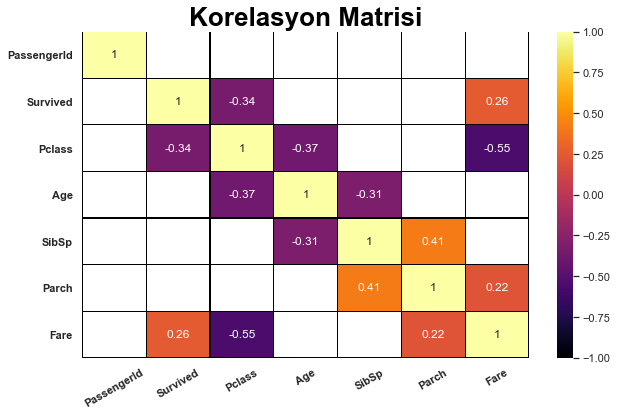

In [25]:
train_data = pd.read_csv("titanic_train.csv")
train_data_corr = train_data.corr()

sns.heatmap(train_data_corr[abs(train_data_corr)>0.2], 
            annot=True, 
            linecolor="black", linewidth=0.1, 
            vmin=-1, vmax=1, 
            cmap="inferno")
plt.yticks(rotation=0, weight="bold")
plt.xticks(rotation=30, weight="bold")
plt.title("Korelasyon Matrisi", fontdict = title_font, size=26)
plt.show()

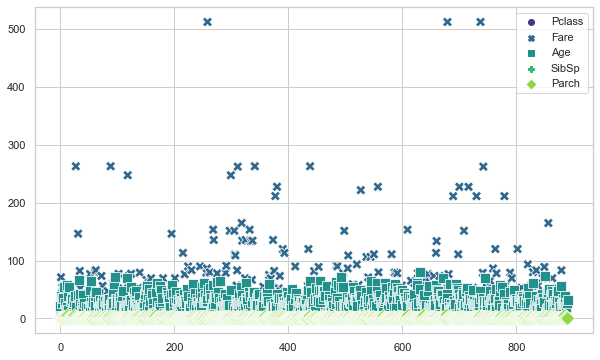

In [26]:
scatter_data = train_data[["Pclass", "Fare", "Age", "SibSp", "Parch"]]

sns.scatterplot(data=scatter_data, 
                s=100, 
                hue = train_data.Survived, 
                palette = 'viridis')

plt.show()